In [32]:
# Imports

import pandas as pd
import numpy as np
import xgboost as xgb
import pickle

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
# Importing our dataset

df = pd.read_csv("cleaned_data.csv")

df.head()

,age_upon_outcome_days,intake_year,time_in_shelter_days,Outcome,Mixed_breed,Purebred,Bird,Cat,Dog,Other,...,Spayed_female,sex_Unknown,Multi_Colour,Solid_Colour,intake_cond_Aged,intake_cond_Feral,intake_cond_Normal,intake_cond_Other,intake_cond_Pregnant_nursing,intake_cond_Unhealthy
0,3650,2017,0.588194,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,2555,2014,1.259722,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,2190,2014,1.113889,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,3650,2014,4.970139,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,5840,2013,0.119444,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [3]:
# defining our features and target variable

X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [4]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                    Specs         Score
0   age_upon_outcome_days  2.127735e+06
2    time_in_shelter_days  5.592533e+05
10            Intact_male  5.025566e+03
13            sex_Unknown  4.711421e+03
9           Intact_female  4.406814e+03
12          Spayed_female  4.257896e+03
11          Neutered_male  2.626443e+03
8                   Other  2.500300e+03
21  intake_cond_Unhealthy  1.349462e+03
4                Purebred  5.377109e+02


In [5]:
# Dropping columns that are not important for prediction

df = df.drop(["intake_year", "Mixed_breed", "intake_cond_Aged", "intake_cond_Normal", "intake_cond_Feral", "intake_cond_Pregnant_nursing", "Multi_Colour", "Solid_Colour", "intake_cond_Other"], axis='columns')

In [6]:
# Seperating numerical and categorical data

numeric_cols = ['age_upon_outcome_days', 'time_in_shelter_days']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'Outcome'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age_upon_outcome_days', 'time_in_shelter_days']
['Bird', 'Cat', 'Dog', 'Intact_female', 'Intact_male', 'Neutered_male', 'Other', 'Purebred', 'Spayed_female', 'intake_cond_Unhealthy', 'sex_Unknown']


In [7]:
# Splitting data into test and train with a test size of 20%

random_seed = np.random.RandomState()

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['Outcome'])

print(df_train.shape)
print(df_test.shape)
print()
print(df_train['Outcome'].value_counts(normalize=True))
print()
print(df_test['Outcome'].value_counts(normalize=True))

(63728, 14)
(15933, 14)

Outcome
0    0.578286
1    0.421714
Name: proportion, dtype: float64

Outcome
0    0.578297
1    0.421703
Name: proportion, dtype: float64


In [8]:
# Scaling numerical columns

scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['Outcome']
    return X, y

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

## Logistic Regression Model

In [9]:
# Fitting model

model = LogisticRegression()

model.fit(X, y)

LogisticRegression()

In [10]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

test_prob = model.predict_proba(X_test)[:, 1]
test_pred = model.predict(X_test)

In [11]:
# Evaluating model results

print('Log loss = {:.3f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.3f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.3f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.3f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.3f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.3f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.3f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.458
AUC = 0.870
Average Precision = 0.800

Using 0.5 as threshold:
Accuracy = 0.775
Precision = 0.690
Recall = 0.847
F1 score = 0.761

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      9214
           1       0.69      0.85      0.76      6719

    accuracy                           0.77     15933
   macro avg       0.78      0.78      0.77     15933
weighted avg       0.79      0.77      0.78     15933



In [12]:
# Hyper-parameter tuning

param_grid = [    
    {
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [13]:
clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [14]:
best_clf = clf.fit(X,y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [15]:
# Finding best parameters

best_clf.best_estimator_

LogisticRegression(C=0.01, solver='newton-cg')

In [16]:
print (f'Accuracy - : {best_clf.score(X,y):.3f}')

Accuracy - : 0.779


In [17]:
# Refitting model with best parameters

model = LogisticRegression(C=0.01, solver='newton-cg', penalty = 'l2')

model.fit(X, y)

LogisticRegression(C=0.01, solver='newton-cg')

In [18]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

test_prob = model.predict_proba(X_test)[:, 1]
test_pred = model.predict(X_test)

In [19]:
print('Accuracy = {:.3f}'.format(accuracy_score(y_test, test_pred)))

Accuracy = 0.776


**We have a better accuracy result after doing some parameter tuning which is great!**

## XGBoost Model

In [20]:
# fit model on training data
model_xgb = XGBClassifier()
model_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

test_prob = model_xgb.predict_proba(X_test)[:, 1]
test_pred = model_xgb.predict(X_test)

In [22]:
# evaluate predictions
accuracy = accuracy_score(y_test, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.09%


In [23]:
# Creating function to find the best parameters to use for model
def random_search_tuning():
    
    params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10],
              'gamma': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
              }
    
    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X, y)

    best_combination = clf.best_params_

    return best_combination

if __name__ == '__main__':
    
    best_params = random_search_tuning()


    print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameter combination:  {'subsample': 0.7999999999999999, 'num_class': 10, 'n_estimators': 750, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}


In [29]:
# fit model with parameters on training data
model_xgb = XGBClassifier(subsample=0.8999999999999999, n_estimators=750, max_depth=6, learning_rate=0.2, colsample_bytree=0.6, colsample_bylevel=0.5, gamma=1)
model_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

test_prob = model_xgb.predict_proba(X_test)[:, 1]
test_pred = model_xgb.predict(X_test)

In [31]:
# evaluate predictions
accuracy = accuracy_score(y_test, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.16%


**We have a slightly higher accuracy score**

Feature: 0, Score: 0.01863
Feature: 1, Score: 0.01504
Feature: 2, Score: 0.02378
Feature: 3, Score: 0.12876
Feature: 4, Score: 0.19639
Feature: 5, Score: 0.29637
Feature: 6, Score: 0.01515
Feature: 7, Score: 0.00909
Feature: 8, Score: 0.08591
Feature: 9, Score: 0.01304
Feature: 10, Score: 0.10935
Feature: 11, Score: 0.03618
Feature: 12, Score: 0.05229


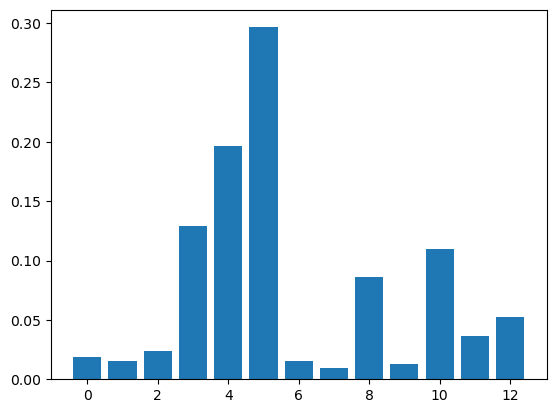

In [27]:
# Checking feature importance

importance = model_xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [33]:
# Saving model

pickle_out = open("model_xgb.pkl", "wb") 
pickle.dump(model_xgb, pickle_out) 
pickle_out.close()